# Grain Size Distribution - Height Correlation Function

Find relevant parameters describing the topography of sputtered Ruthenium thin films on Si substrate
How:
- Roughness RMS
- Fit exponential increase
- Take intersection between RMS asymptote and Fit

Output parameters:
- Roughness
- Correlation Length
- Alpha exponent

In [45]:
import os
import sys

import numpy as np

import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

from matplotlib import cm

from skimage import data, img_as_float, filters
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from skimage import exposure


import cv2
import plotly.graph_objects as go

%reload_ext autoreload
%matplotlib nbagg
%autoreload 2
%aimport AFM_lib

In [58]:
debug = True #or 'False' when you do not want to debug

path = "/Users/sfiligoj/Desktop/Thesis/Data Analysis/AFM/SSP"
os.chdir(path)
new_folder_name = "ALL1/Quads"
if not os.path.exists(f"{new_folder_name}"):
    os.mkdir(f"{new_folder_name}")
    
filess = os.listdir()
filess = [f for f in filess if f.endswith('txt')]

In [59]:
#open dictionary of Scan Size values:
with open('ScanSizes.json', 'r') as f:
    ScanSize_dict = json.loads(f.read())

12
running file:Ru_H_800C_FLAT.008.txt, quadrant 0


<IPython.core.display.Javascript object>


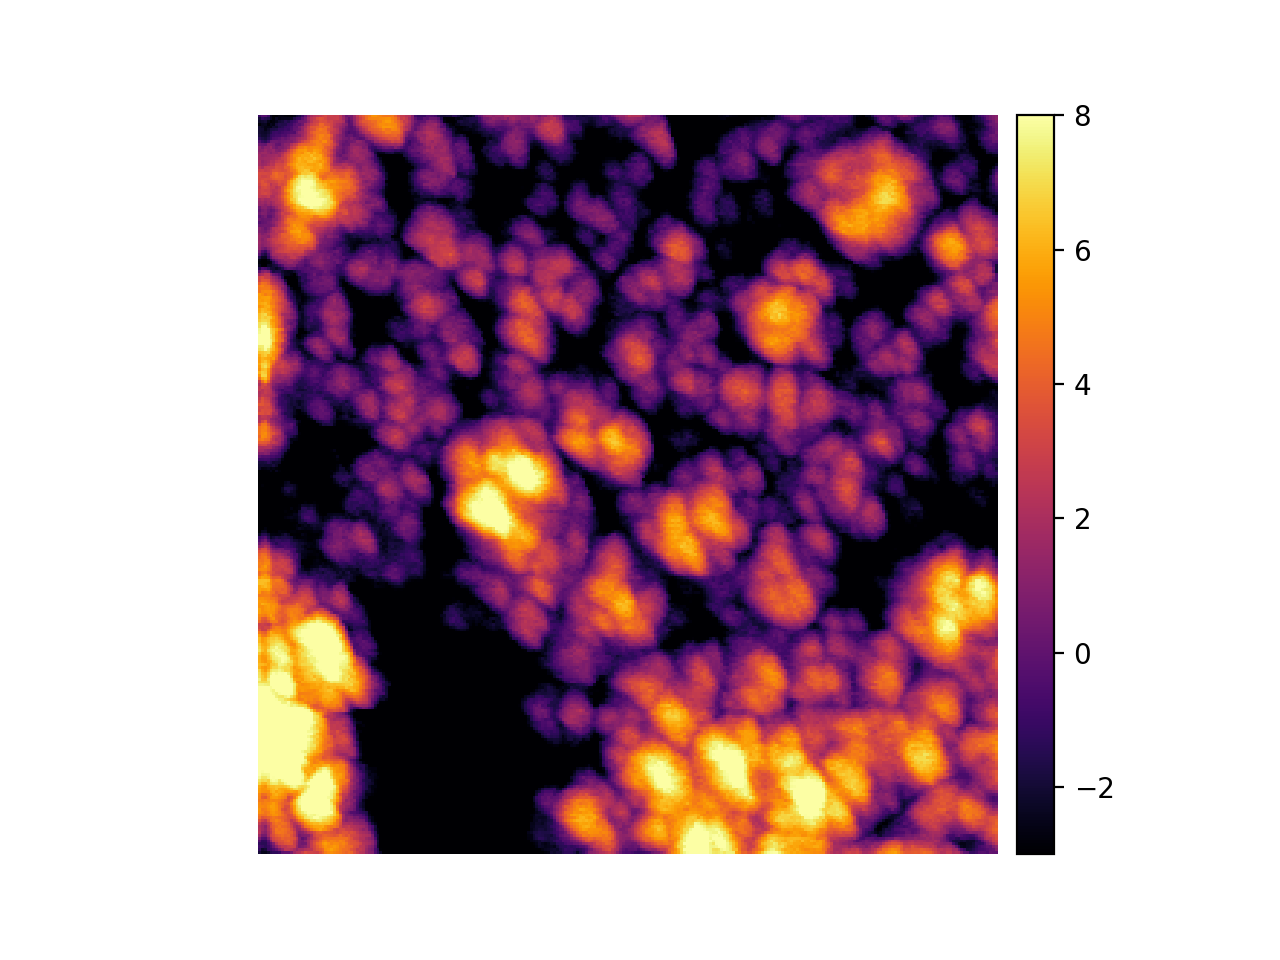

running file:Ru_H_800C_FLAT.008.txt, quadrant 1


<IPython.core.display.Javascript object>


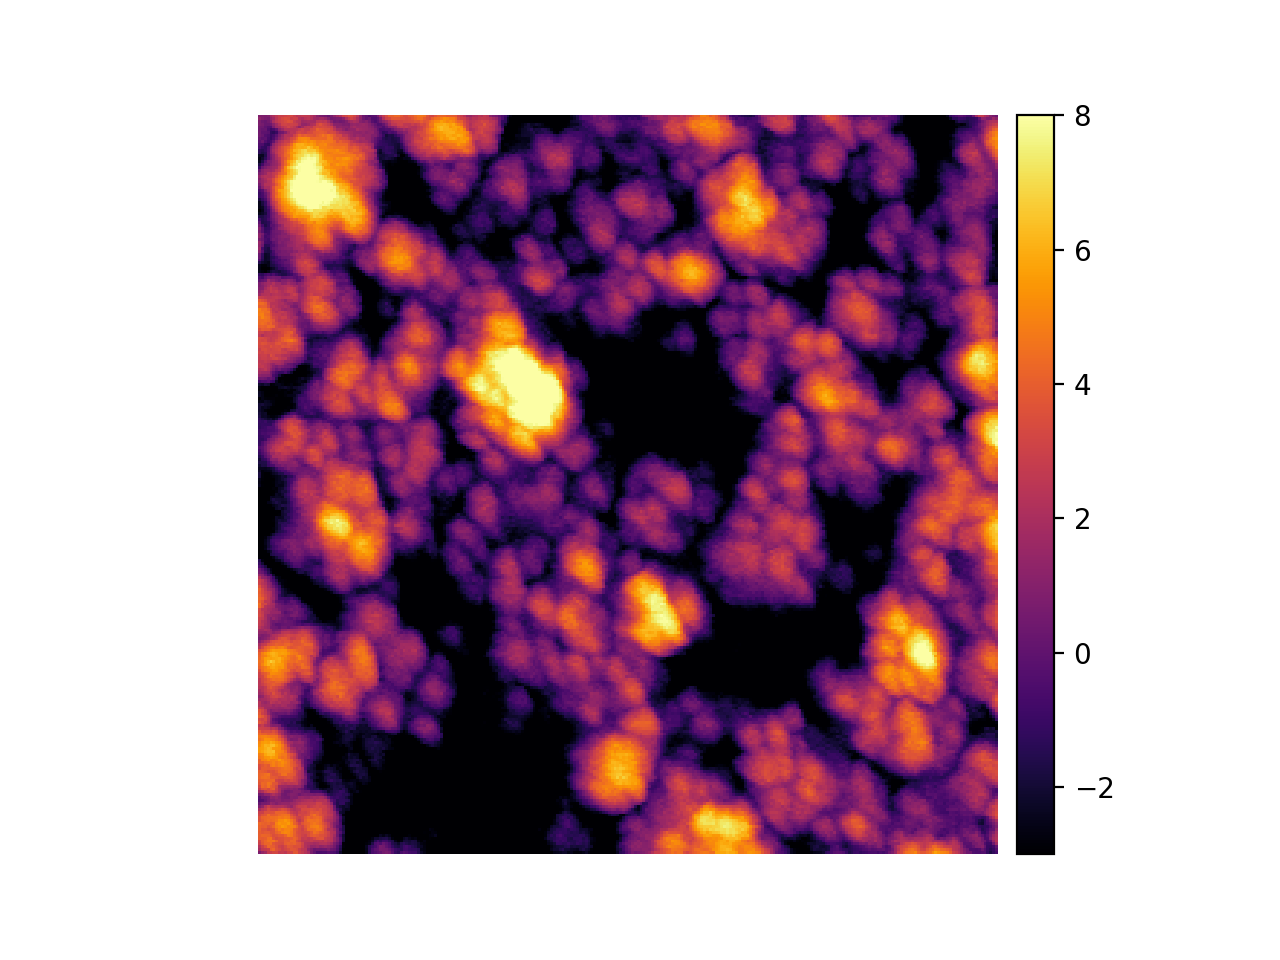

running file:Ru_H_800C_FLAT.008.txt, quadrant 2


<IPython.core.display.Javascript object>


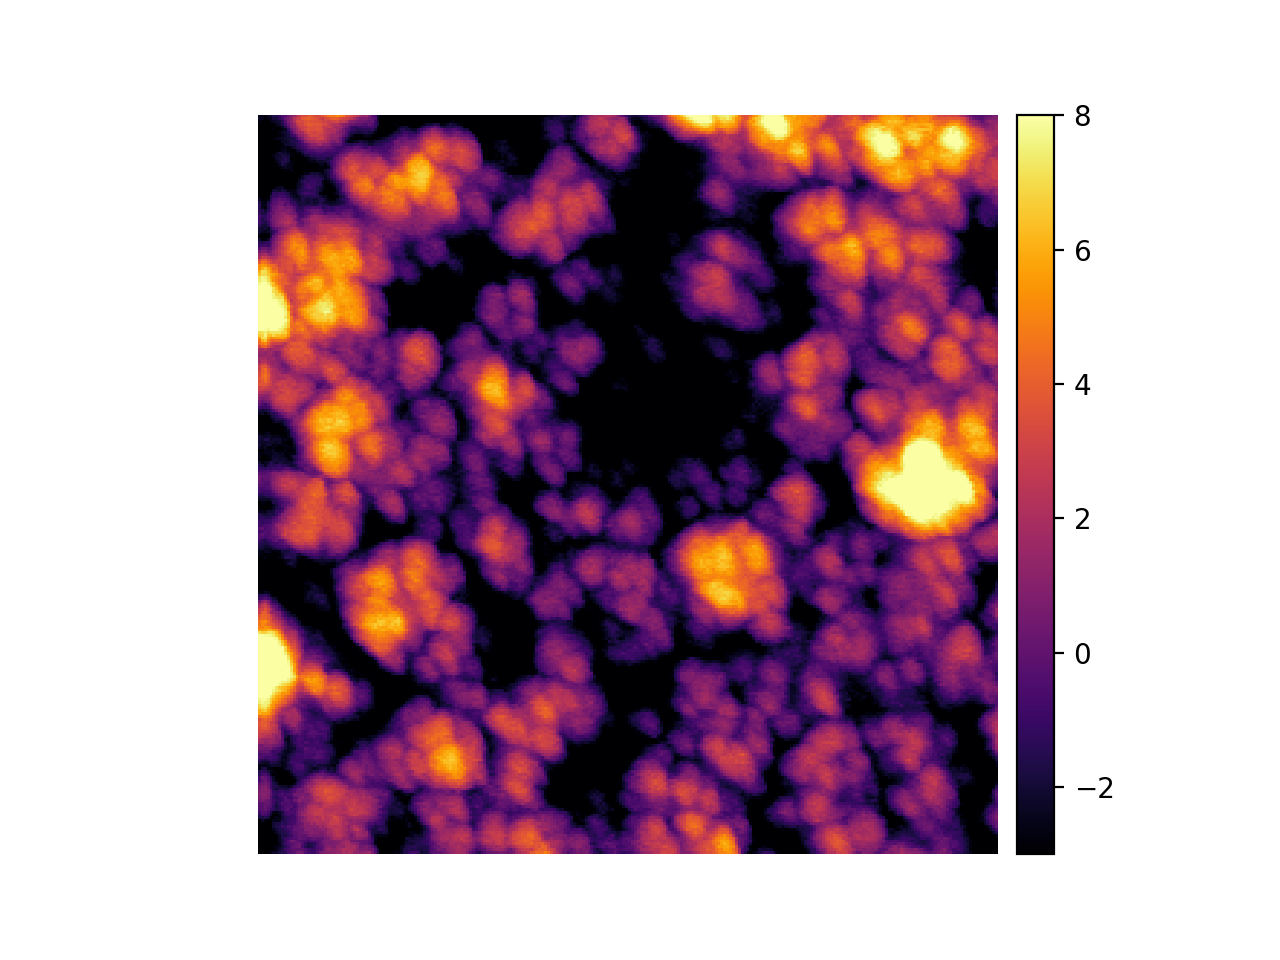

running file:Ru_H_800C_FLAT.008.txt, quadrant 3


<IPython.core.display.Javascript object>


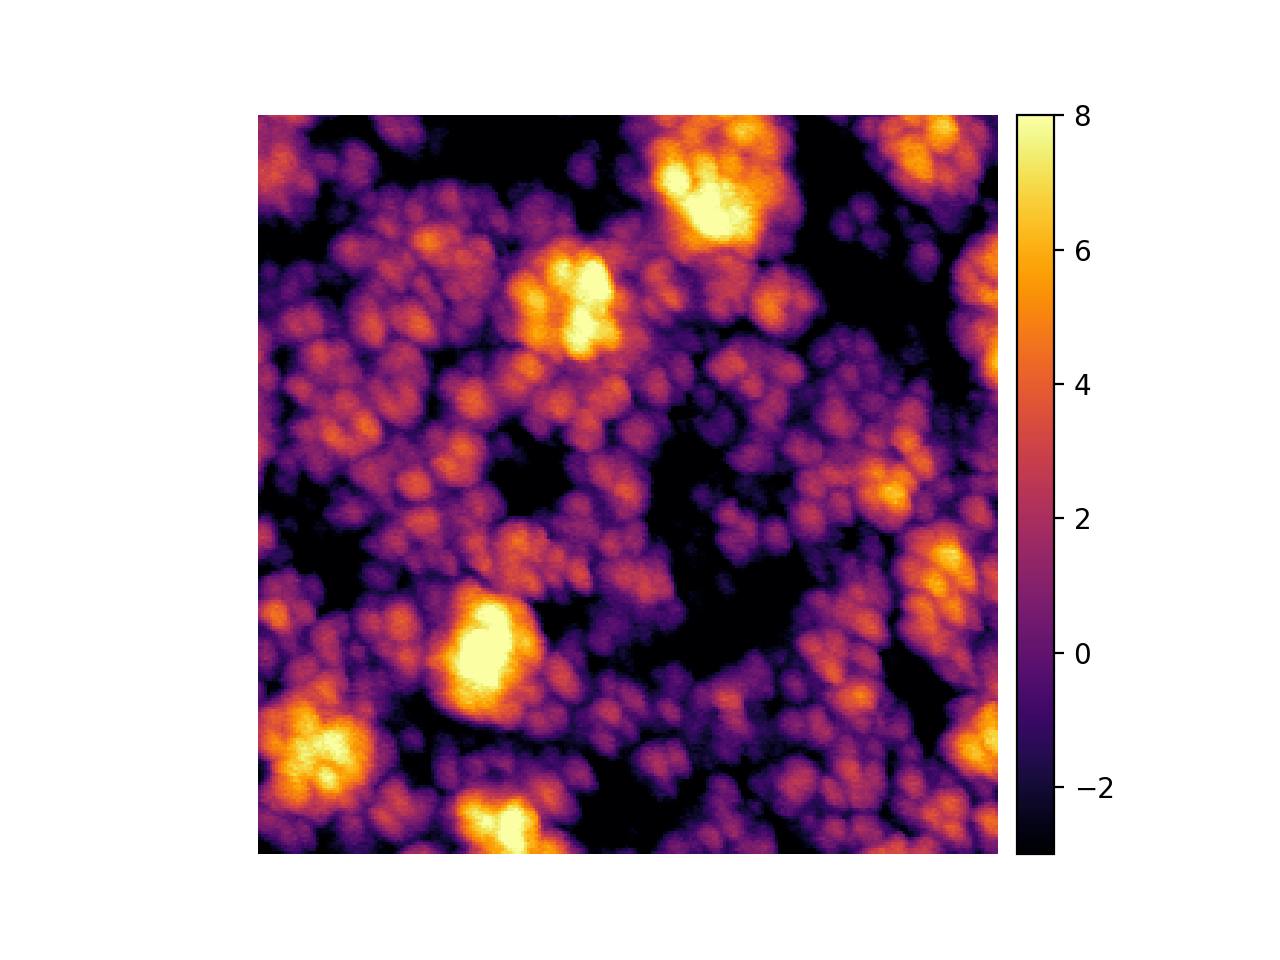

66
running file:Ru_H_800C_FLAT.010.txt, quadrant 0


<IPython.core.display.Javascript object>


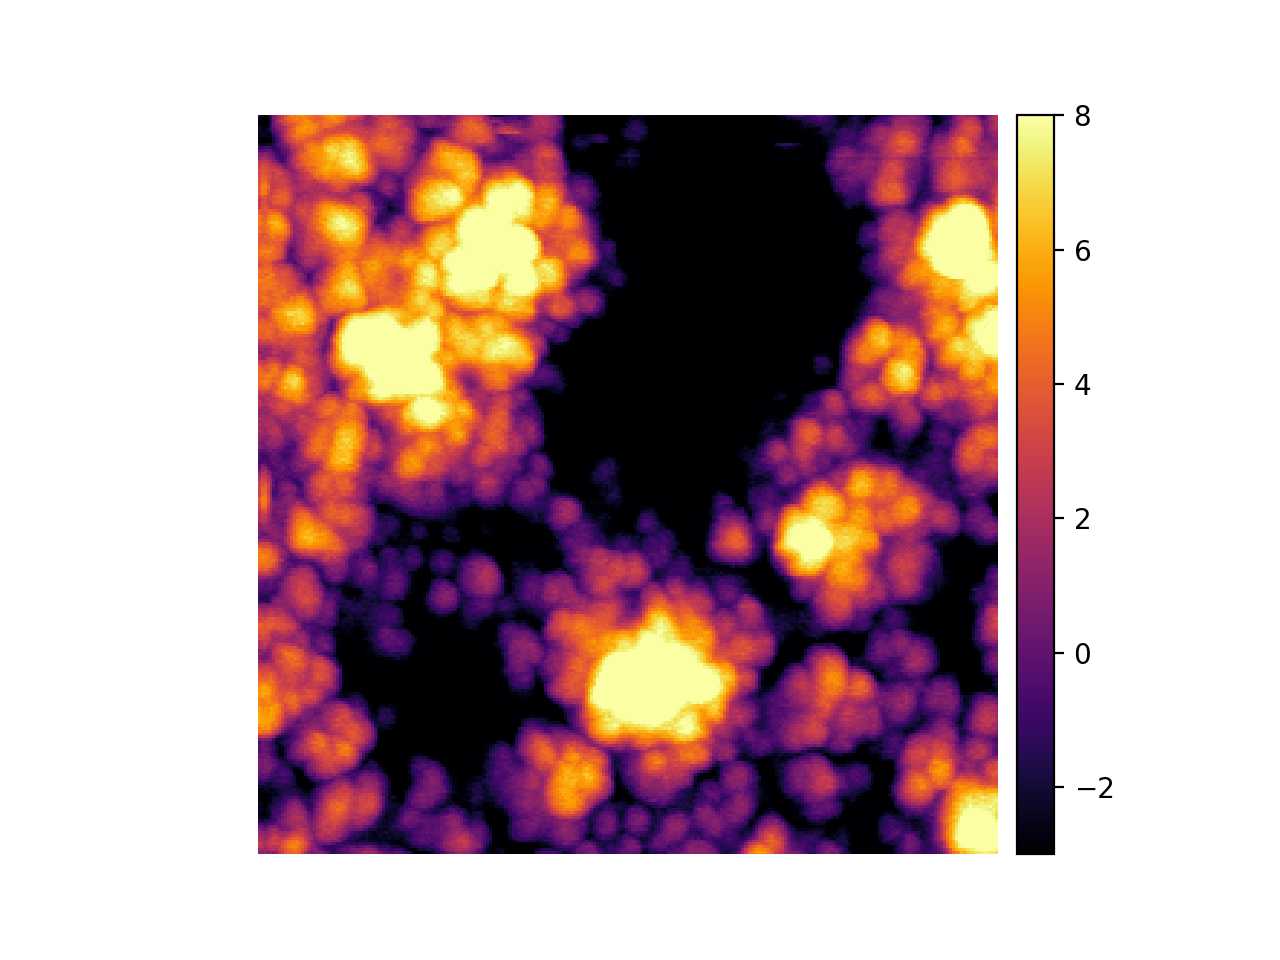

running file:Ru_H_800C_FLAT.010.txt, quadrant 1


<IPython.core.display.Javascript object>


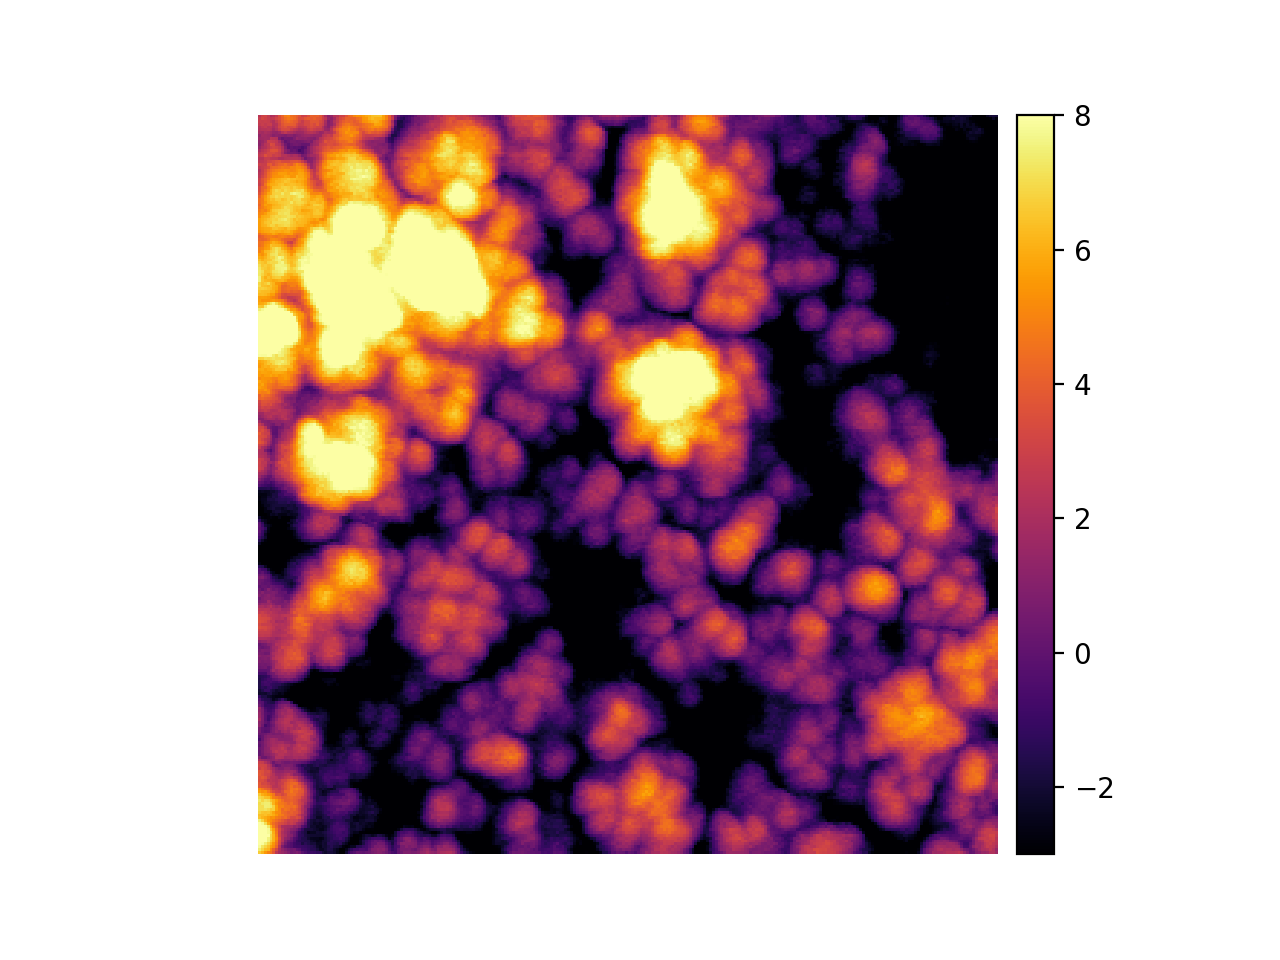

running file:Ru_H_800C_FLAT.010.txt, quadrant 2


<IPython.core.display.Javascript object>


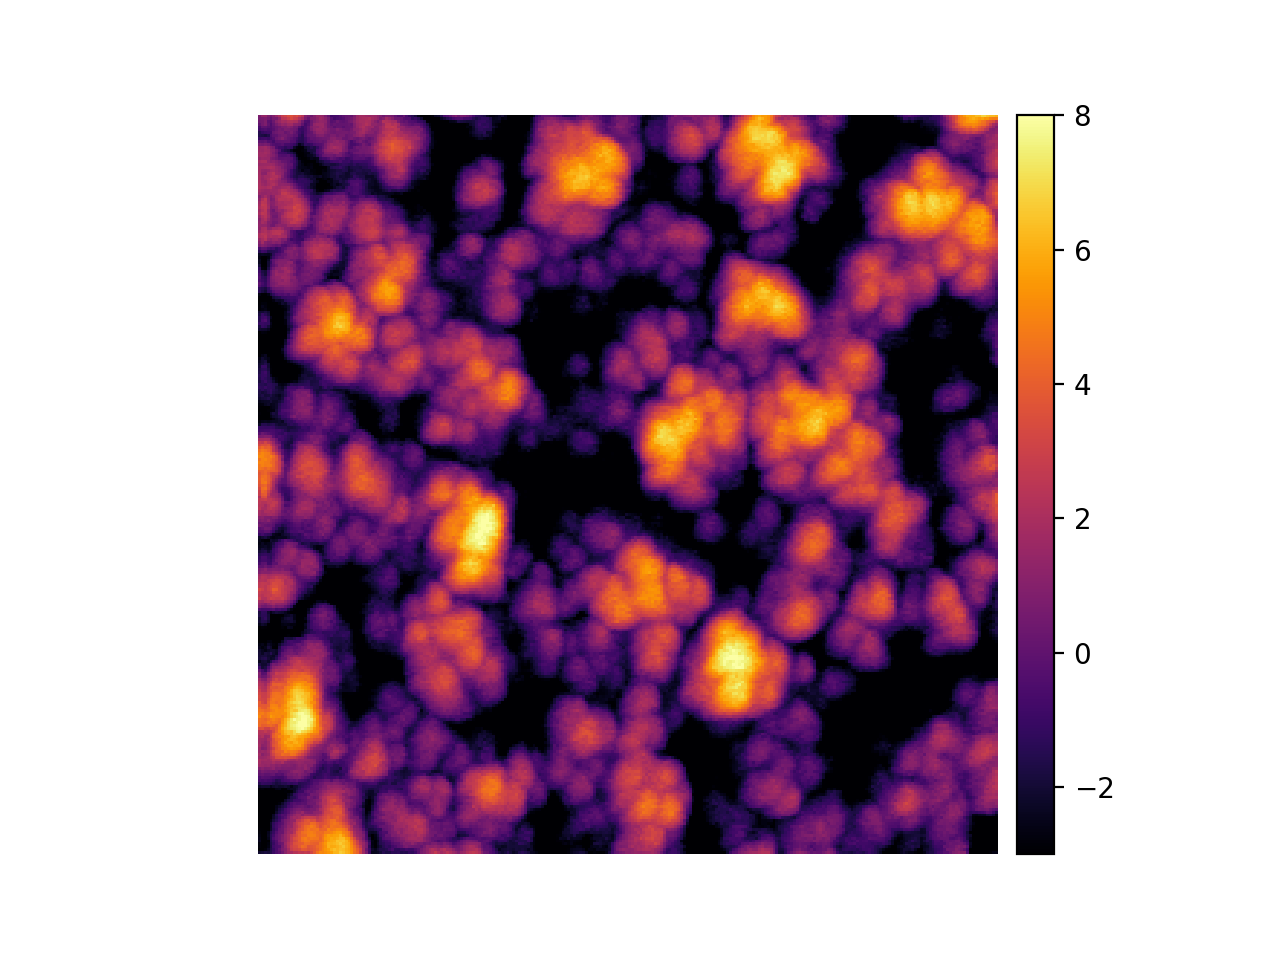

running file:Ru_H_800C_FLAT.010.txt, quadrant 3


<IPython.core.display.Javascript object>


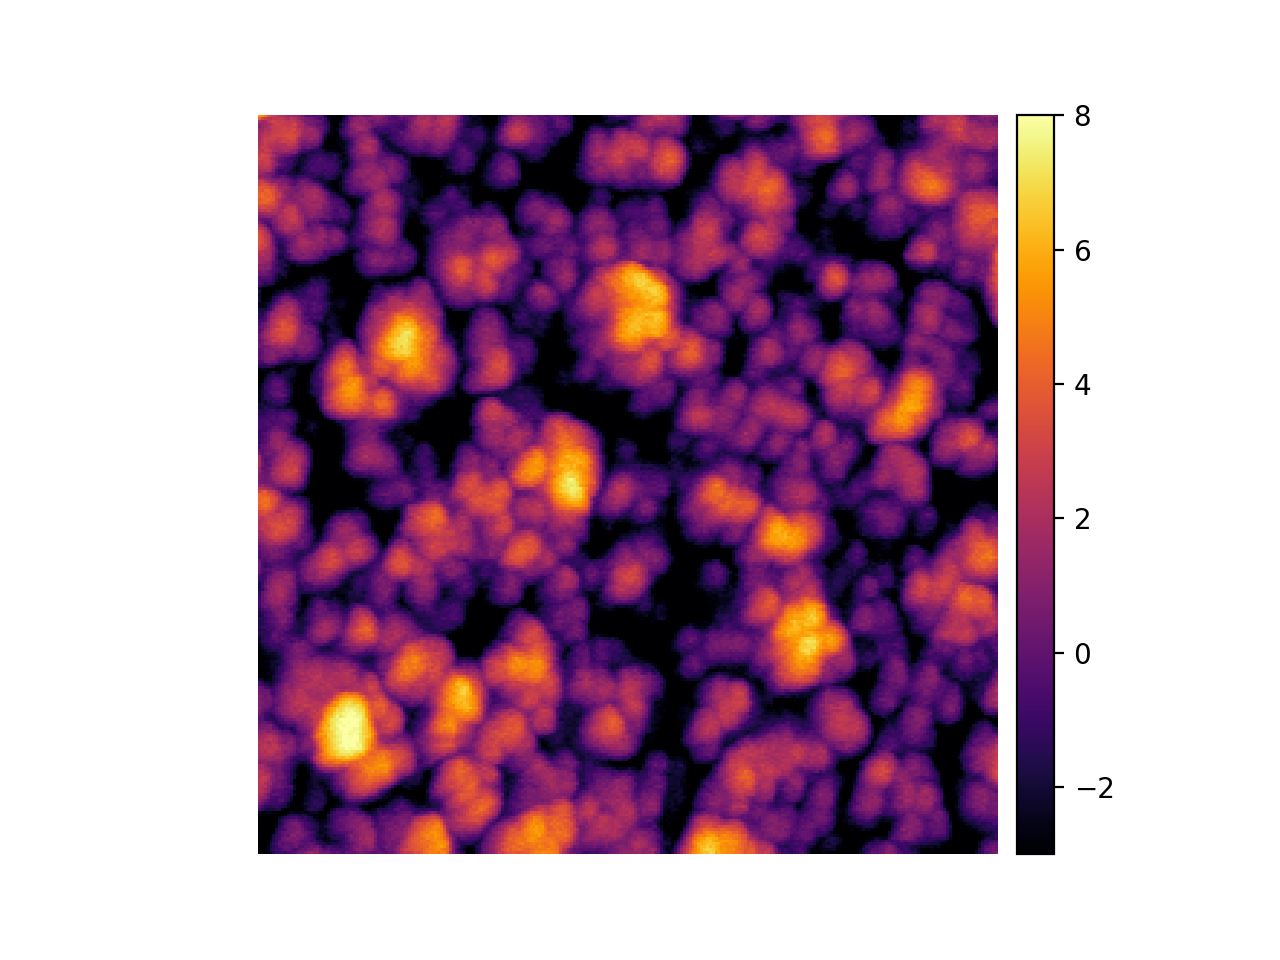

75
running file:Ru_H_800C_XPS_FLAT.033.txt, quadrant 0


<IPython.core.display.Javascript object>


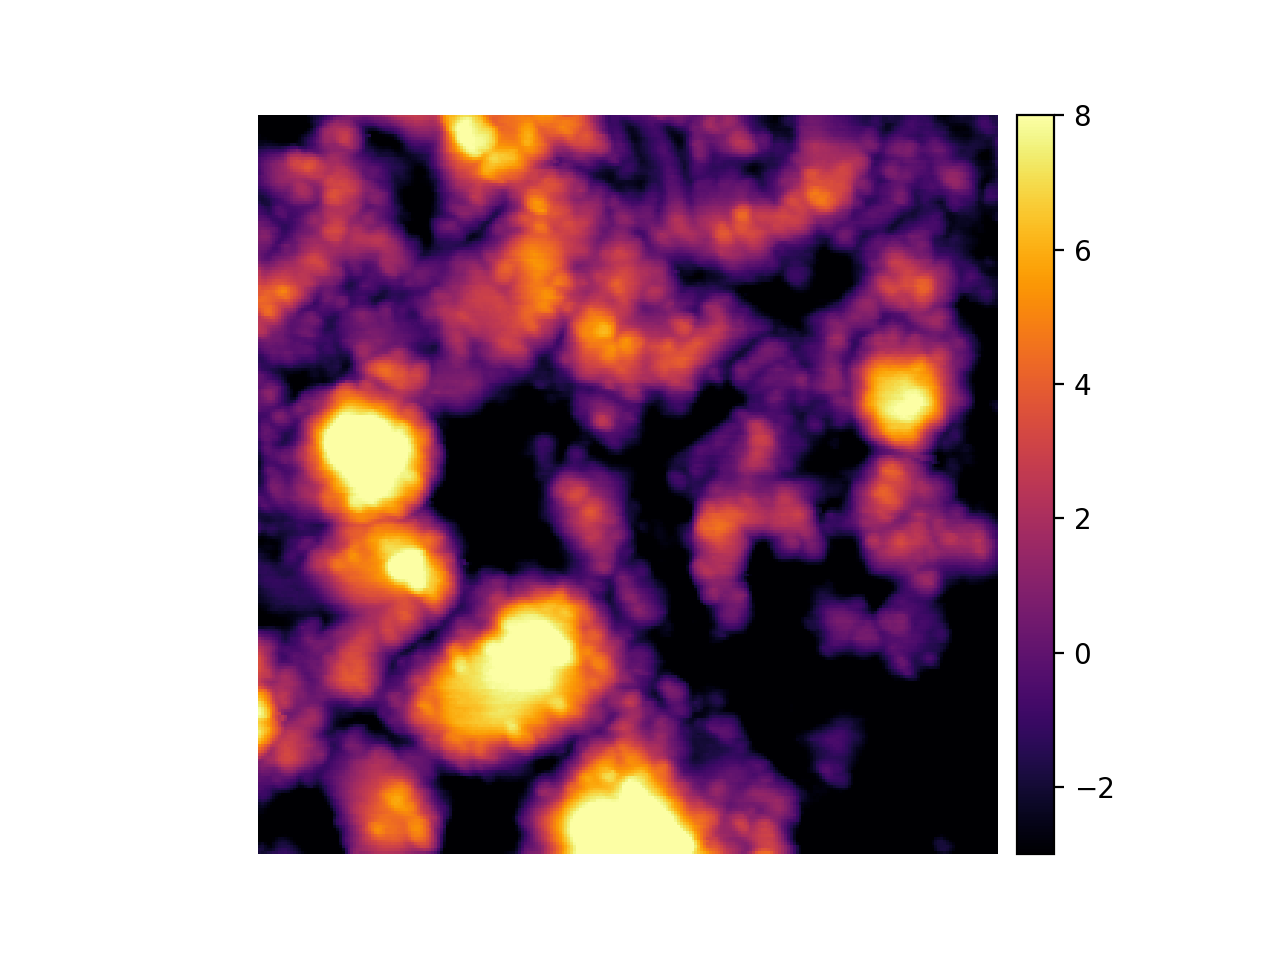

running file:Ru_H_800C_XPS_FLAT.033.txt, quadrant 1


<IPython.core.display.Javascript object>


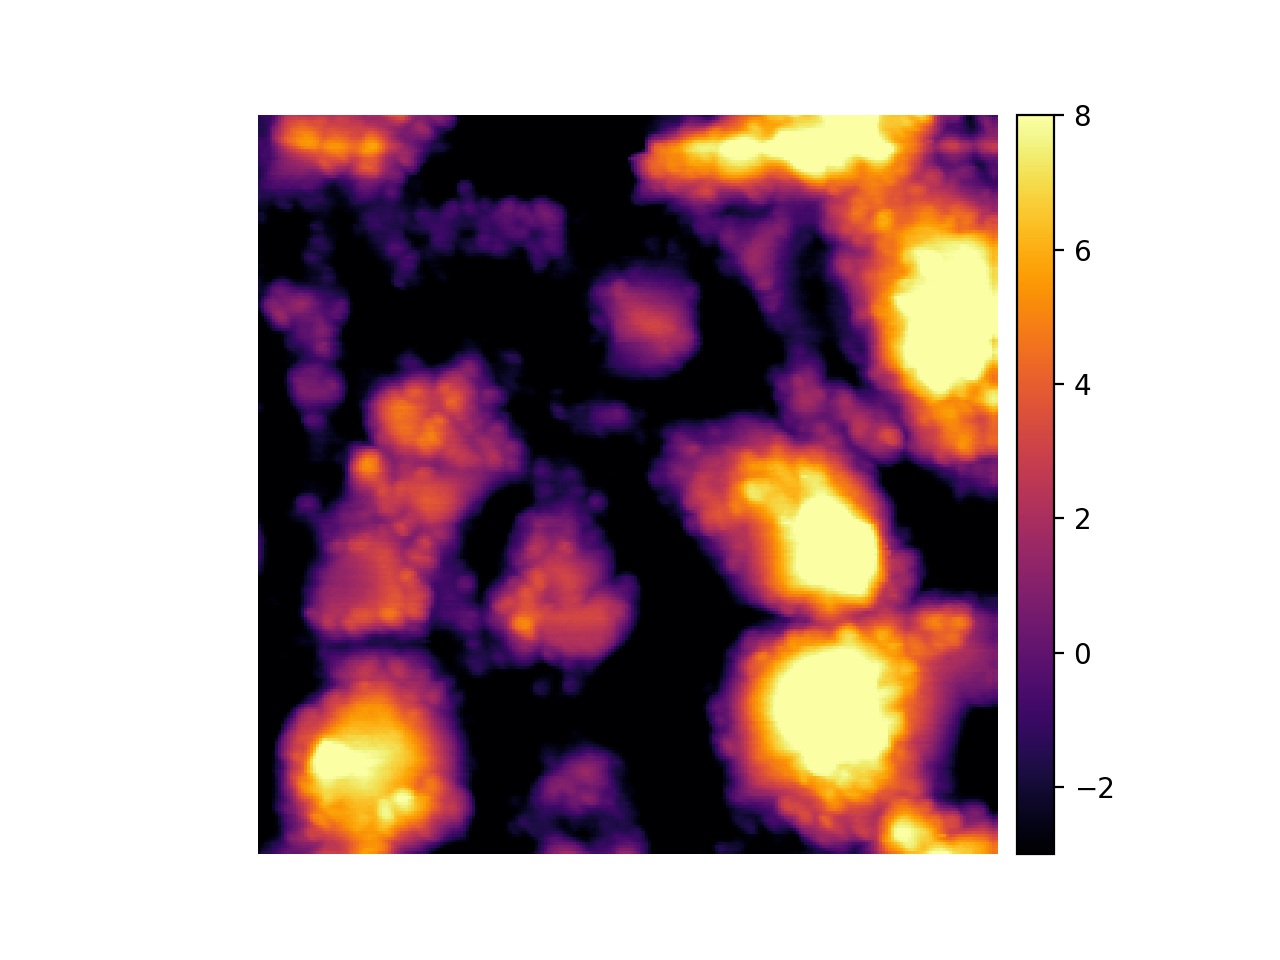

running file:Ru_H_800C_XPS_FLAT.033.txt, quadrant 2


<IPython.core.display.Javascript object>


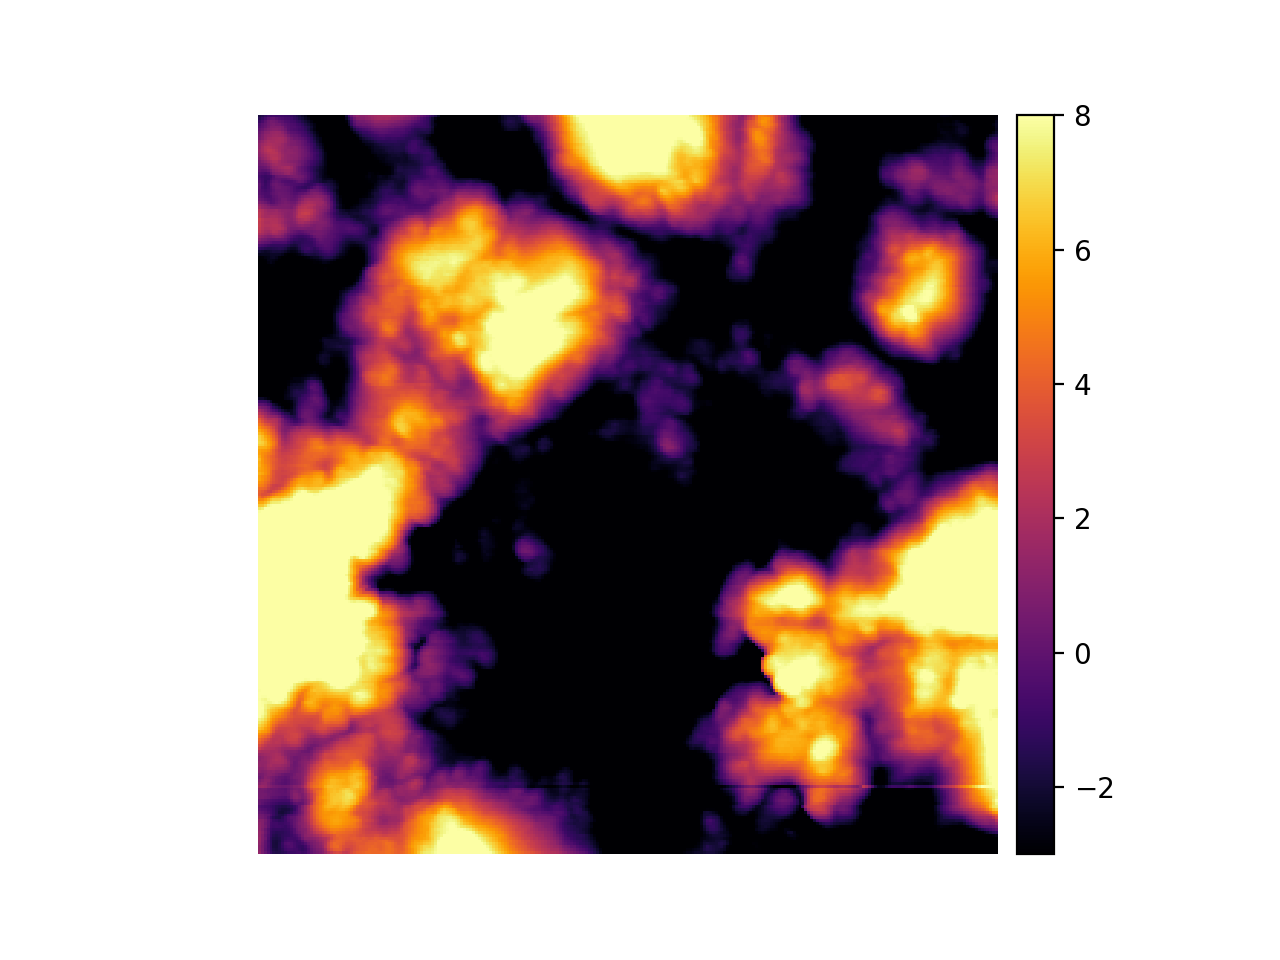

running file:Ru_H_800C_XPS_FLAT.033.txt, quadrant 3


<IPython.core.display.Javascript object>


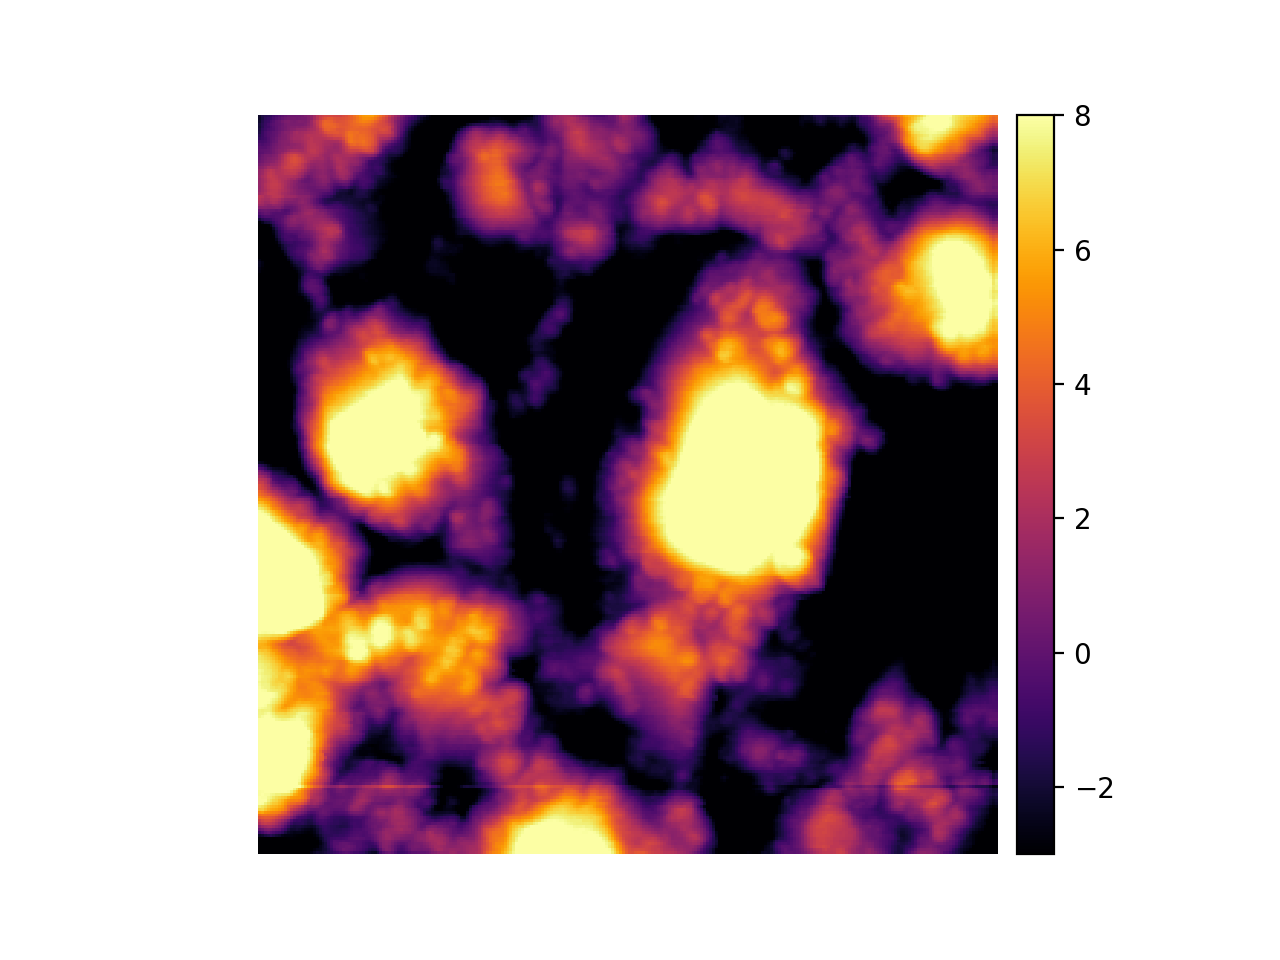

In [63]:
plotting = True
data = dict.fromkeys(filess)

for i,file in enumerate(filess[:]):
    
    if '*' in file:
        continue   
    elif 'Ru_S_'in file:
        continue
#     if 'Si' in file:
#         continue
    elif 'um' in file:
        continue   
    elif '_H_' in file:
#         continue
        density = 'High'
        if '800C' in file:
            temperature = '800C'
        else:
            continue
            temperature = temperature = file[5:9]        
    elif '_L_' in file:
        continue
        density = 'Low'
        if 'asdep' in file:
            temperature = 'asdep'
        else:
#             continue
            temperature = temperature = file[5:9]          
    elif '_LH_' in file:
        continue
        density = 'Low-High'
        if 'asdep' in file:
            temperature = 'asdep'
        else:
#             continue
            temperature = temperature = file[6:10]
            
    data[file] = {}
    print(i)
    
    filesize = os.path.getsize(file)     #to differentiate between 512x512 px or 1024x1024 px img
    Pix_width = int(np.sqrt(filesize/32))
    Pix_height = Pix_width
    
    data[file]['img'] = np.genfromtxt(file, skip_header=1).reshape((Pix_width,Pix_height))
    
    rows, cols = data[file]['img'].shape
    midrows = rows // 2
    midcols = cols // 2
    
    quadrant1 = data[file]['img'][:midrows ,:midcols]
    quadrant2 = data[file]['img'][:midrows , midcols:]
    quadrant3 = data[file]['img'][ midrows:,:midcols]
    quadrant4 = data[file]['img'][ midrows:, midcols:]

    
    quadrants = [quadrant1, quadrant2, quadrant3, quadrant4]
    
    img_wo_outliers = {}
    img_rescale={}
    img={}
    vmin={}
    vmax={}
    img2={}
    pI={}
    pF={}
    for j,quad in enumerate(quadrants):
        print(f'running file:{file}, quadrant {j}')
        img_wo_outliers[j] ={}
        img_rescale[j]={}
        img[j]={}
#         vmin[j]={}
#         vmax[j]={}
#         img2[j]={}
#         pI[j]={}
#         pF[j]={}
        #remove outliers:
#         img_wo_outliers[j] = AFM_lib.remove_outliers(quad,threshold=3)   

        #Take contrast correction on image without outliers:
#         pI[j], pF[j] = np.percentile(img_wo_outliers[j], (0.5, 99.5))

        #Apply contrast correction
#         img_rescale[j] = exposure.rescale_intensity(quad, in_range=(pI[j], pF[j]))
#         vmin[j] = quad.min()
#         vmax[j] = quad.max()

#         cbar = fig.colorbar(img[j], 
#                             cax=cax, 
# #                             ticks = [vmin,vmax])
#         cbar.set_ticklabels([f"{vmin:.3} nm",f"{vmax:.3} nm"])


        fig,ax = plt.subplots(1,1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        
        vmin=-3.0
        vmax= 4.0
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            
        # Apply contrast correction
#         img_rescale[j] = exposure.rescale_intensity(quad, in_range=(vmin, vmax))

        img[j] = ax.imshow(quad,
                           norm=norm, 
                           cmap="inferno")
        
        cb1 = mpl.colorbar.ColorbarBase(cax, 
                                        cmap="inferno",
                                        norm=norm)

        ax.axis('off')

        fname = f"HH function for {temperature} {density} density Ru - {file[-7:-4]}_{j}"
        fig.savefig(f"{new_folder_name}/{fname}.png", dpi=600)
        fig.savefig(f"{new_folder_name}/{fname}.svg", dpi=600)

In [ ]:
fig.show

In [ ]:
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=5, vmax=10)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,